In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import pygrib
import pickle
import numpy as np
import pandas as pd
import netCDF4 as nc

# stats tools
from skgstat import Variogram
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr, spearmanr
from scipy.stats import norm
# ANN tools
#from tensorflow import keras

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import matplotlib.path as path

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

In [2]:
%matplotlib inline

In [3]:
cmap_mae = plt.cm.plasma_r # MAE colormap
cmap_line = plt.cm.plasma_r # line color "base"
camp_tmax_hist = plt.cm.plasma_r # TMAX histogram colormap
camp_tmin_hist = plt.cm.viridis_r # TMIN histogram colormap
camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

line_colors = [cmap_line(45), cmap_line(90), cmap_line(135), cmap_line(180), cmap_line(225)]

C1 = plt.cm.plasma(96)[:3]
C2 = plt.cm.plasma(225)[:3]
C3 = plt.cm.viridis(180)[:3]

In [4]:
with h5py.File(save_dir+'NAEFS_single_test.hdf', 'r') as hio:
    lon_4km = hio['lon_4km'][...]
    lat_4km = hio['lat_4km'][...] 
    lon_025 = hio['lon_025'][...] 
    lat_025 = hio['lat_025'][...]
    lon_ncep = hio['lon_ncep'][...]
    lat_ncep = hio['lat_ncep'][...] 
    TMEAN_NCEP = hio['TMEAN_NCEP'][...] 
    TMEAN_REGRID = hio['TMEAN_REGRID'][...] 
    TMEAN_clean = hio['TMEAN_clean'][...] 
    TMEAN_4km = hio['TMEAN_4km'][...]

In [5]:
with h5py.File(PRISM_dir+'land_mask_NA.hdf', 'r') as hdf_io:
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]
    lon_025 = hdf_io['lon_025'][...]
    lat_025 = hdf_io['lat_025'][...]
    land_mask_025 = hdf_io['land_mask_025'][...]
    land_mask = hdf_io['land_mask'][...]
    etopo_4km = hdf_io['etopo_4km'][...]
    etopo_regrid = hdf_io['etopo_regrid'][...]

In [6]:
flag_mask = griddata((lon_025.ravel(), lat_025.ravel()), land_mask_025.ravel(), (lon_ncep, lat_ncep), method='linear')
flag_mask[np.isnan(flag_mask)]=True

## Obs

In [7]:
with pd.HDFStore(OBS_dir+'obs_verif.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']
stn_lat = metadata['lat'].values
stn_lon = metadata['lon'].values
stn_elev = metadata['elev'].values
stn_code = metadata['stn code'].values

In [8]:
# BC stations
with h5py.File(PRISM_dir+'PRISM_regrid_BC_clim.hdf', 'r') as h_io:
    land_mask_BC = h_io['land_mask'][...]
    lon_BC = h_io['lon_4km'][...]
    lat_BC = h_io['lat_4km'][...]
    
indx, indy = du.grid_search(lon_BC, lat_BC, stn_lon, stn_lat)
flag_pick = ~land_mask_BC[indx, indy]
flag_pick[indx==np.min(indx)]=False
flag_pick[indx==np.max(indx)]=False
flag_pick[indy==np.min(indy)]=False
flag_pick[indy==np.max(indy)]=False

In [9]:
N = 365 + 365
dt_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N)]
OBS = np.zeros([N, len(stn_code)])
with pd.HDFStore(OBS_dir+'obs_verif.hdf', 'r') as hdf_temp:
    for i, code in enumerate(stn_code):
        OBS[:, i] = hdf_temp[code]['value'].values
OBS = OBS*0.1 # units conversion

In [10]:
indx_ncep, indy_ncep = du.grid_search(lon_ncep, lat_ncep, stn_lon, stn_lat)
indx_4km, indy_4km = du.grid_search(lon_4km, lat_4km, stn_lon, stn_lat)

In [15]:
OBS_NCEP = TMEAN_NCEP[:, indx_ncep, indy_ncep][:, flag_pick]
OBS_4km = TMEAN_4km[:, indx_4km, indy_4km][:, flag_pick]

In [16]:
OBS_BC = np.copy(OBS[181, flag_pick])

### Talagrand Diagram

In [17]:
def heavyside(thresholds, actual):
    # Given a deterministic observation, make a CDF out of it
    result = [1 if t >= actual else 0 for t in thresholds]
    return result

In [18]:
flag_val = ~np.isnan(OBS_BC)
OBS_BC = OBS_BC[flag_val]
#OBS_norm = OBS_norm[flag_val]
OBS_4km = OBS_4km[:, flag_val]
OBS_NCEP = OBS_NCEP[:, flag_val]

In [19]:
HIST_NCEP = np.zeros([23])
HIST_4km = np.zeros([23])
for i in range(np.sum(flag_val)):
    ranks_NCEP = np.array([-np.inf]+sorted(OBS_NCEP[:, i])+[np.inf])
    temp_id = np.searchsorted(ranks_NCEP, OBS_BC[i])
    HIST_NCEP[temp_id] += 1
    
    ranks_4km = np.array([-np.inf]+sorted(OBS_4km[:, i])+[np.inf])
    temp_id = np.searchsorted(ranks_4km, OBS_BC[i])
    HIST_4km[temp_id] += 1
HIST = np.concatenate((HIST_NCEP[1:][None, :], HIST_4km[1:][None, :]), axis=0)

In [20]:
mu_NCEP = np.mean(OBS_NCEP, axis=0)
std_NCEP = np.std(OBS_NCEP, axis=0)
x_NCEP = np.zeros([len(OBS_BC), 500])

mu_4km = np.mean(OBS_4km, axis=0)
std_4km = np.std(OBS_4km, axis=0)
x_4km = np.zeros([len(OBS_BC), 500])

for i in range(len(OBS_BC)):
    x_NCEP[i, :] = np.linspace(-5, 35, 500)
for i in range(len(OBS_BC)):
    x_4km[i, :] = np.linspace(-5, 35, 500)
    
CDF_OBS = np.zeros([len(OBS_BC), 500])
for i in range(len(OBS_BC)):
    CDF_OBS[i, :] = heavyside(np.linspace(-5, 35, 500), OBS_BC[i])

In [21]:
delta = np.linspace(-5, 35, 500)[1]-np.linspace(-5, 35, 500)[0]
CRPS_NCEP = np.zeros(len(OBS_BC))
CRPS_4km = np.zeros(len(OBS_BC))
for i in range(len(OBS_BC)):
    CRPS_NCEP[i] = np.sum(np.abs(norm.cdf(x_NCEP[i, :], mu_NCEP[i], std_NCEP[i])-CDF_OBS[i, :])*delta)
    CRPS_4km[i] = np.sum(np.abs(norm.cdf(x_4km[i, :], mu_4km[i], std_4km[i])-CDF_OBS[i, :])*delta)

[None, None, None]

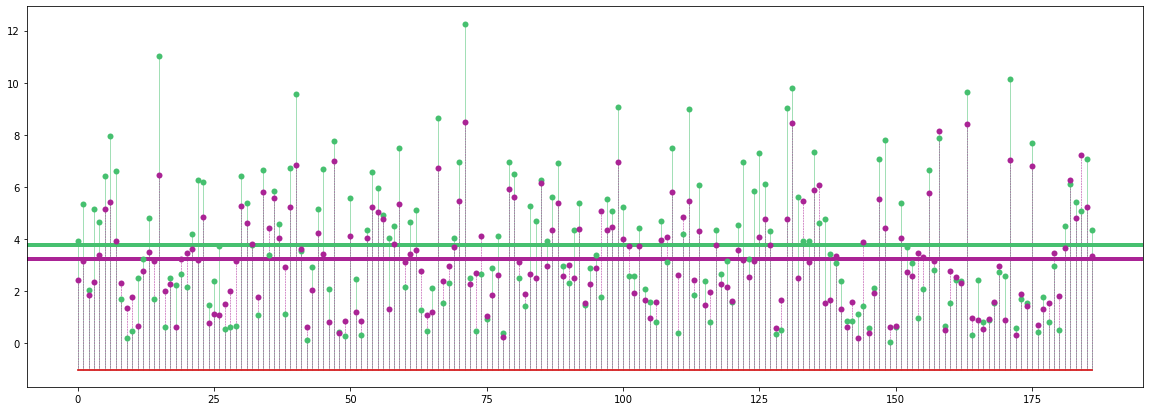

In [22]:
fig = plt.figure(figsize=(20, 7))
ax = fig.gca()
ax.axhline(np.mean(CRPS_NCEP), xmin=0, xmax=1, color=C3, lw=4, ls='-')
ax.axhline(np.mean(CRPS_4km), xmin=0, xmax=1, color=C1, lw=4, ls='-')

markerline, stemline, baseline = ax.stem(np.arange(len(OBS_BC)), CRPS_NCEP, bottom=-1, use_line_collection=True)
plt.setp(markerline, marker='o', markersize=6, mew=0, mfc=C3)
plt.setp(stemline, linewidth=0.5, color=C3)

markerline, stemline, baseline = ax.stem(np.arange(len(OBS_BC)), CRPS_4km, bottom=-1, use_line_collection=True)
plt.setp(markerline, marker='o', markersize=6, mew=0, mfc=C1)
plt.setp(stemline, linewidth=0.5, linestyle='--', color=C1)

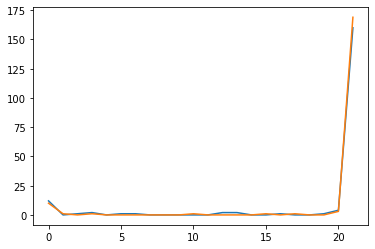

In [25]:
plt.plot(HIST.T)

In [26]:
HIST

array([[ 12.,   0.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   2.,   2.,   0.,   0.,   1.,   0.,   0.,   1.,   4., 160.],
       [ 10.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   3., 169.]])

In [228]:
std_4km

array([0.15824074, 0.20323032, 0.19296455, 0.16298191, 0.26545666,
       0.15383291, 0.16584278, 0.17577068, 0.15677273, 0.1375148 ,
       0.18610851, 0.28190745, 0.12307319, 0.30255969, 0.1693778 ,
       0.3746183 , 0.10925075, 0.15494547, 0.2046287 , 0.17620013,
       0.18017901, 0.17967469, 0.37960458, 0.26457817, 0.22231046,
       0.20980645, 0.18712633, 0.33896532, 0.10925075, 0.11765055,
       0.35708248, 0.35952008, 0.09590729, 0.14079532, 0.25451174,
       0.16079921, 0.23396931, 0.17546024, 0.12349051, 0.40628836,
       0.41651031, 0.09968301, 0.07282174, 0.17226461, 0.25599383,
       0.26248134, 0.26360389, 0.21386043, 0.1016704 , 0.16193168,
       0.12540085, 0.20980645, 0.25200349, 0.19721736, 0.26457817,
       0.25599383, 0.15169503, 0.27852553, 0.12691173, 0.15988768,
       0.1749599 , 0.18598003, 0.39657876, 0.18745707, 0.20349432,
       0.22927639, 0.38931444, 0.15870664, 0.18917494, 0.19301626,
       0.36383565, 0.17472099, 0.32303189, 0.13313298, 0.17667

In [227]:
std_NCEP

array([0.19998711, 0.24413118, 0.27478032, 0.15814179, 0.33157319,
       0.19573172, 0.21909972, 0.20794934, 0.12438086, 0.06921223,
       0.22315695, 0.3159089 , 0.10955151, 0.37664582, 0.22315695,
       0.35686187, 0.08806525, 0.19301893, 0.25244287, 0.22315695,
       0.22315695, 0.21814765, 0.38127937, 0.34031081, 0.33013423,
       0.22594004, 0.15839201, 0.52768581, 0.08806525, 0.04019465,
       0.48678469, 0.52768581, 0.10955151, 0.27833346, 0.25100721,
       0.23405054, 0.32933573, 0.19998711, 0.07174545, 0.48678469,
       0.49077692, 0.10955151, 0.04338334, 0.23405054, 0.2910637 ,
       0.20609253, 0.39029572, 0.33013423, 0.13652622, 0.22315695,
       0.15814179, 0.22594004, 0.39029572, 0.27478032, 0.34031081,
       0.2910637 , 0.23405054, 0.52768581, 0.15814179, 0.18891462,
       0.22315695, 0.20609253, 0.43923283, 0.22315695, 0.28404786,
       0.30429217, 0.48678469, 0.19301893, 0.22315695, 0.27833346,
       0.38127937, 0.15228574, 0.49077692, 0.09016038, 0.22315

In [225]:
mu_4km

array([13.72462041, 10.44097483, 10.39689713, 13.52275308, 10.34079066,
        9.15041188,  8.22290386, 12.651528  , 10.74539375, 11.06474486,
       13.61881147,  6.29348625, 13.16132114,  8.98218895, 13.40529551,
       14.47804592, 10.63550073, 13.74815814, 11.74546664, 14.26969247,
       13.6917498 , 10.48026566, 11.4240576 ,  8.80285363,  9.92600268,
        8.24220476, 10.68184212, 14.53937372, 10.63550073, 11.16621989,
       11.67327409, 14.46166343, 12.7892843 , 11.52018488,  8.11328958,
        6.82905545,  8.83576121, 13.28282047, 11.47522767, 12.32750498,
       12.89854926, 12.68135434, 11.30032766,  6.54283723, 11.41001915,
       10.73600624, 10.13424587, 11.26433618, 10.34115142, 14.3942268 ,
       11.56329668,  8.24220476,  9.8552881 , 10.50754824,  8.80285363,
       11.41001915,  7.59658116, 15.46103591, 11.5073873 ,  8.52056072,
       13.91306673,  8.25347546, 11.70056652, 13.42945199, 10.59732619,
        9.85518773, 12.29584085, 12.3511001 , 14.14185252, 12.93

In [106]:
N = 365 + 365
date_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N)]

<BarContainer object of 23 artists>

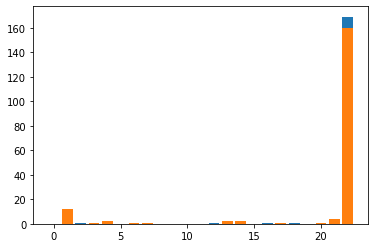

In [107]:


plt.bar(np.arange(23), HIST_4km)
plt.bar(np.arange(23), HIST_NCEP)

In [68]:
HIST_4km

array([  0.,  10.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   1.,
       169.])

In [73]:
temp_id

22

In [108]:
HIST_4km

array([  0.,  10.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   1.,
       169.])

In [109]:
HIST_NCEP

array([  0.,  12.,   0.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,   0.,
         0.,   0.,   2.,   2.,   0.,   0.,   1.,   0.,   0.,   1.,   4.,
       160.])

In [4]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

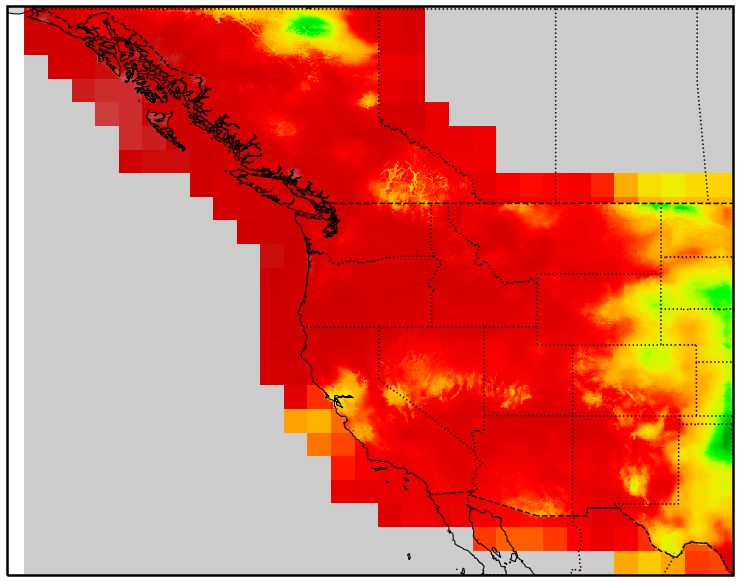

In [15]:
fig = plt.figure(figsize=(13, 13))
ax_base = fig.gca(projection=ccrs.PlateCarree())
ax_base.set_extent([-141, -100, 28, 58.5], ccrs.Geodetic())
ax_base.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.85')
ax_base.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=1.5)
ax_base.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5)
ax_base.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=1.5)
ax_base.outline_patch.set_linewidth(2.5)
ax_base.pcolormesh(lon_4km, lat_4km, np.nanstd(TMEAN_4km, 0), vmin=0, vmax=2, cmap=plt.cm.nipy_spectral_r)

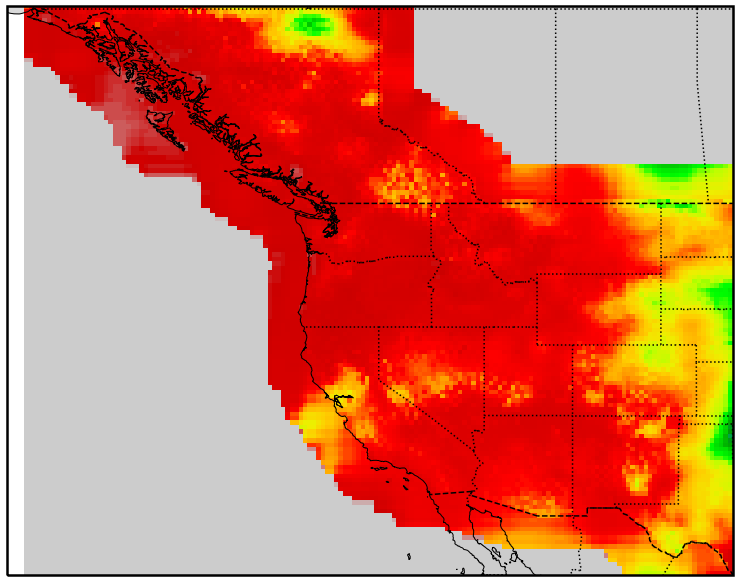

In [20]:
fig = plt.figure(figsize=(13, 13))
ax_base = fig.gca(projection=ccrs.PlateCarree())
ax_base.set_extent([-141, -100, 28, 58.5], ccrs.Geodetic())
ax_base.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.85')
ax_base.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=1.5)
ax_base.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5)
ax_base.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=1.5)
ax_base.outline_patch.set_linewidth(2.5)
ax_base.pcolormesh(lon_025, lat_025, np.nanstd(TMEAN_clean, 0), vmin=0, vmax=2, cmap=plt.cm.nipy_spectral_r)

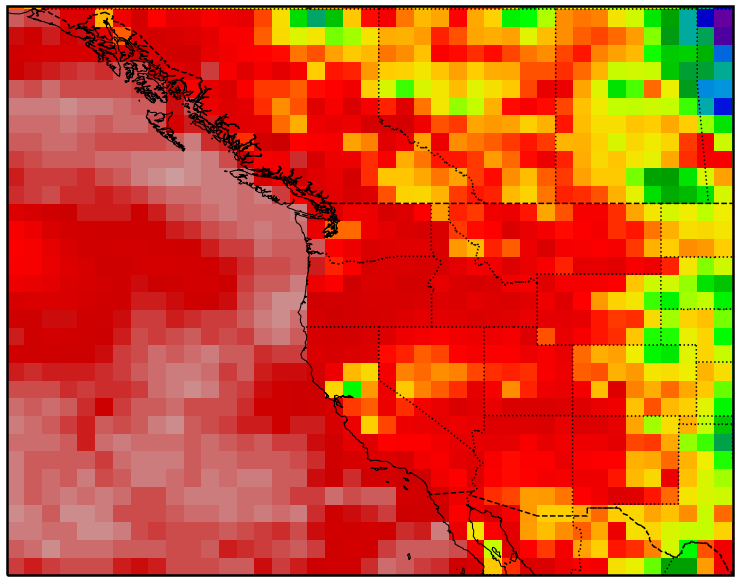

In [16]:
fig = plt.figure(figsize=(13, 13))
ax_base = fig.gca(projection=ccrs.PlateCarree())
ax_base.set_extent([-141, -100, 28, 58.5], ccrs.Geodetic())
ax_base.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.85')
ax_base.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=1.5)
ax_base.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5)
ax_base.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=1.5)
ax_base.outline_patch.set_linewidth(2.5)
ax_base.pcolormesh(lon_ncep, lat_ncep, np.nanstd(TMEAN_NCEP, 0), vmin=0, vmax=2, cmap=plt.cm.nipy_spectral_r)

In [17]:
np.max(np.nanstd(TMEAN_NCEP, 0))

5.10841528783037

In [18]:
np.max(np.nanstd(TMEAN_4km, 0))

1.1453051161545271

In [22]:
np.max(np.nanstd(TMEAN_clean, 0))

1.1549680352674303